In [2]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [3]:
import os 
import numpy as np
import itertools
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 8.3.2
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.9.11
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          8.0.6
jedi                0.18.1
joblib              1.2.0
jupyter_server      1.23.2
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.36.0
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.53.1
numpy               1.20.3
packaging           21.3
pandas              1.5.1
parso  

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 13#17
MEDIUM_SIZE = 15#19
BIGGER_SIZE = 17#21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["legend.markerscale"] = 3

rcParams['figure.figsize']= (10,10)

In [5]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

## DE heatmaps

In [68]:
combs_of_interest = {
    "skull_only"    : ['Skull'],    
    #"vertebra_only" : ['Vertebra'],    
    #"femur_only"    : ['Femur'],  
    #"skull_vertebra": ['Skull','Vertebra'],
    "not_skull"     : ['Pelvis', 'Femur', 'Vertebra', 'Humerus'],# 'Scapula'],
    #"not_vertebra"  : ['Skull', 'Pelvis', 'Femur', 'Humerus'],# 'Scapula'],
    ##"not_scapula"   : ['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'],
    #"all_bones"     : ['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'],# 'Scapula'],
}

def filter_combination(df,combination):
    """
    """
    bones = np.array(['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    #bones = np.array(['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis'])#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula'])
    filt = True
    for b in combination:
        filt = filt & df[b].astype(bool)
    for b in [b for b in bones if (b not in combination)]:
        filt = filt & ~df[b].astype(bool)   
    return df.loc[filt].copy()


def upset_dfs(adata,ct_key="level1",condition = "Naive",pval_max=0.05,LFchange_min=1,n_cts=None):
    """
    
    n_cts: int
        Keep `n_cts` cell types with the highest numbers of DE genes and put the other cell types in group "other".
    """
    bones = np.array(['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    #bones = np.array(['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis'])#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula'])    
    df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff_{DATA_VERSION}/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
    
    df = df.loc[(df["pvals_adj"] < pval_max) & (df["logfoldchanges"] > LFchange_min)]
    if n_cts:
        cts_to_show = df["celltype"].value_counts().nlargest(n_cts).index.values
        df.loc[~df["celltype"].isin(cts_to_show),"celltype"] = "other"
    
    color_df = pd.DataFrame(data={"celltype":[ct for ct in adata.obs[ct_key].cat.categories if ct in df["celltype"].unique()] + ["other"],
                       "color"   :[adata.uns[f"{ct_key}_colors"][i] for i,ct in enumerate(adata.obs[ct_key].cat.categories ) if ct in df["celltype"].unique()] + ["#808080"]
                      }
                )
    return df, color_df


def upset_dfs_all_conds(adata,ct_key="level1",pval_max=0.05,LFchange_min=1,n_cts=None):
    """
    
    n_cts: int
        Keep `n_cts` cell types with the highest numbers of DE genes and put the other cell types in group "other".
    """
    bones = np.array(['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    #bones = np.array(['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis'])#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula'])    
    
    dfs = []
    for condition in ["Naive","Sham","MCAO"]:
        df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff_{DATA_VERSION}/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
        
        df = df.loc[(df["pvals_adj"] < pval_max) & (df["logfoldchanges"] > LFchange_min)]
        if n_cts:
            cts_to_show = df["celltype"].value_counts().nlargest(n_cts).index.values
            df.loc[~df["celltype"].isin(cts_to_show),"celltype"] = "other"
            
        df["condition"] = condition
        dfs.append(df)
        #df = df.rename(columns={bone:f"{condition} {bone}" for bone in bones})
    df = pd.concat(dfs)
    
    
    color_df = pd.DataFrame(data={"celltype":[ct for ct in adata.obs[ct_key].cat.categories if ct in df["celltype"].unique()] + ["other"],
                       "color"   :[adata.uns[f"{ct_key}_colors"][i] for i,ct in enumerate(adata.obs[ct_key].cat.categories ) if ct in df["celltype"].unique()] + ["#808080"]
                      }
                )
    return df, color_df


from matplotlib.colors import ListedColormap

def DE_heatmap_df(adata,ct_key="level1",pval_max=0.05,LFchange_min=1,min_genes_per_comb=5):
    """
    """
    
    # Load results #TODO: LOAD ALL 3 AND CONCATENATE
    #df,_ = upset_dfs(adata,ct_key=ct_key,condition = condition,pval_max=pval_max,LFchange_min=LFchange_min,n_cts=None)
    df,_ = upset_dfs_all_conds(adata,ct_key=ct_key,pval_max=pval_max,LFchange_min=LFchange_min,n_cts=None)
    
    # Reshape dataframe for heatmap
    #bones = np.array(['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis']) #TODO: convert to 'Skull Naive', etc.

    crs = np.array([
        'Naive Skull', 'Naive Vertebra', 'Naive Humerus', 'Naive Femur', 'Naive Pelvis',
        'Sham Skull', 'Sham Vertebra', 'Sham Humerus', 'Sham Femur', 'Sham Pelvis',
        'MCAO Skull', 'MCAO Vertebra', 'MCAO Humerus', 'MCAO Femur', 'MCAO Pelvis'
    ])        
    
    df_hm = pd.DataFrame(columns = ["combination","celltype","condition"] + crs.tolist())
    df_hm[crs] = df_hm[crs].astype(float)
    for comb_name,comb in combs_of_interest.items():
        df_tmp = filter_combination(df,comb)
        if len(df_tmp) > min_genes_per_comb:
            ct_order = df_tmp["celltype"].value_counts().index.tolist()
            df_tmp["tmp"] = df_tmp["celltype"].apply(lambda x: ct_order.index(x))
            df_tmp = df_tmp.sort_values(["condition","tmp","pvals"],ascending=True)
            df_hm_tmp = df_tmp[["celltype","condition"]].copy()
            df_hm_tmp["combination"] = comb_name
            # HERE WE INSERT THE CONDITION 
            df_hm_tmp["combination"] = df_hm_tmp["combination"] + "_" + df_hm_tmp["condition"]
            df_hm = pd.concat([df_hm,df_hm_tmp])
    # Sort according condition, rest sticks the same
    df_hm["condition"] = df_hm["condition"].astype("category").cat.reorder_categories(["Naive","Sham","MCAO"])
    df_hm["order"] = [i for i in range(len(df_hm))]
    df_hm = df_hm.sort_values(["condition","order"])
    df_hm["condition"] = df_hm["condition"].astype(str)
            
    # Calculate mean expressions per cell type
    for ct in df_hm["celltype"].unique():
        for cr in crs:
            filt = (adata.obs["condition region"] == cr) & (adata.obs[ct_key] == ct)
            genes = df_hm.loc[df_hm["celltype"]==ct].index
            a = adata[filt,genes]
            if a.n_obs > 1: # Actually we shouldn't need this! Was only in there because I head the group "other" frp,
                means = a.X.mean(axis=0,dtype=np.float64)
                means = np.asarray(means[-1]).reshape(-1) if issparse(a.X) else means[-1]
            else:
                means = np.zeros(len(genes))
            df_hm.loc[df_hm["celltype"]==ct,cr] = means
    
    # Scale mean expressions to min-max 1-0
    df_hm_scaled = df_hm.copy()
    df_hm_scaled[crs] = df_hm_scaled[crs].values - df_hm_scaled[crs].min(axis=1).values[:,np.newaxis]
    df_hm_scaled[crs] = df_hm_scaled[crs].values / df_hm_scaled[crs].max(axis=1).values[:,np.newaxis]  
    
    return df_hm_scaled
    
def DE_heatmap(df_hm_scaled,adata,ct_key="level1",figsize=(8,10),show=True,save=False,dpi=200,reverse_df=False,ct_leg_y_pos=1):    
    
    #if ("Calvaria" in df_hm_scaled.columns) and ("MCAo" in df_hm_scaled.columns):
    crs = np.array([
        'Naive Calvaria', 'Naive Vertebra', 'Naive Humerus', 'Naive Femur', 'Naive Pelvis',
        'Sham Calvaria', 'Sham Vertebra', 'Sham Humerus', 'Sham Femur', 'Sham Pelvis',
        'MCAo Calvaria', 'MCAo Vertebra', 'MCAo Humerus', 'MCAo Femur', 'MCAo Pelvis'
    ])
    #else:
    #    crs = np.array([
    #        'Naive Skull', 'Naive Vertebra', 'Naive Humerus', 'Naive Femur', 'Naive Pelvis',
    #        'Sham Skull', 'Sham Vertebra', 'Sham Humerus', 'Sham Femur', 'Sham Pelvis',
    #        'MCAO Skull', 'MCAO Vertebra', 'MCAO Humerus', 'MCAO Femur', 'MCAO Pelvis'
    #    ])
    
    #if "Calvaria" in df_hm_scaled.columns:
    #    bones = np.array(['Calvaria', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    #else:
    #    bones = np.array(['Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    ##bones = np.array(['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis'])#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula'])
    
    if reverse_df:
        df_hm_scaled = df_hm_scaled[::-1].copy()
    
    # Prepare Colors 
    # For combinations    
    combination_colors = {
        "skull_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Skull")],
        "calvaria_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Skull")],
        "vertebra_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Vertebra")],
        "femur_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Femur")],
        "skull_vertebra" : "purple",
        "calvaria_vertebra" : "purple",        
        "not_skull" : "grey",
        "not_calvaria" : "grey",        
        "not_vertebra" : "blue",
        #"not_scapula" : "brown",
        "all_bones" : "gold",
    }
    combination_colors_tmp = {comb+"_"+cond:color for cond in ["Naive","Sham","MCAo"] for comb,color in combination_colors.items()}
    combination_colors = combination_colors_tmp
    combination_colors = {comb:color for comb,color in combination_colors.items() if comb in df_hm_scaled["combination"].unique()}
    combs_color_order = [key for key in combination_colors]
    #combs_color_order = ['skull_only_Naive', 'not_skull_Naive', 'skull_only_Sham', 'not_skull_Sham', 'skull_only_MCAO', 'not_skull_MCAO']
    combs_colors = [color for _,color in combination_colors.items()]
    # For conditions
    cond_cats = []
    cond_colors = []
    for i, cat in enumerate(adata.obs["condition"].cat.categories):
        cond_cats.append(cat)
        cond_colors.append(adata.uns[f"condition_colors"][i])
    cond_cats = ["MCAo" if c == "MCAO" else c for c in cond_cats]
    # For cell types    
    cats = []
    ct_colors = []
    for i, cat in enumerate(adata.obs[ct_key].cat.categories):
        cats.append(cat)
        ct_colors.append(adata.uns[f"{ct_key}_colors"][i])
    ct_colors_leg = {ct:color for ct,color in zip(cats,ct_colors) if (ct in df_hm_scaled["celltype"].tolist())}
    #ct_colors_leg = {ct:color for ct,color in zip(cats,ct_colors)}
    # Columns for color codes
    df_hm_scaled["condition_idx"] = df_hm_scaled["condition"].apply(lambda x: cond_cats.index(x))
    df_hm_scaled["celltype_idx"] = df_hm_scaled["celltype"].apply(lambda x: cats.index(x))
    df_hm_scaled["combination_idx"] = df_hm_scaled["combination"].apply(lambda x: combs_color_order.index(x))
    ct_colors = ct_colors[df_hm_scaled["celltype_idx"].min():df_hm_scaled["celltype_idx"].max()+1]
    cond_colors = cond_colors[df_hm_scaled["condition_idx"].min():df_hm_scaled["condition_idx"].max()+1]
    
    # Plot
    fig = plt.figure(figsize=figsize)
    #ax1 = plt.subplot2grid((3,10), (0,0), rowspan=3, colspan= 1) # ((3,15), (0,0), rowspan=3, colspan= 1))
    #ax2 = plt.subplot2grid((3,10), (0,1), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    #ax3 = plt.subplot2grid((3,10), (0,2), rowspan=3, colspan= 7) # ((3,15), (0,2), rowspan=3, colspan=12)) 1.5 per bone = 1.5 * 5 = 6.5 ~ 7
    #ax4 = plt.subplot2grid((3,10), (2,9), rowspan=1, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))
    
    #ax1 = plt.subplot2grid((3,25), (0,0), rowspan=3, colspan= 1) # ((3,15), (0,0), rowspan=3, colspan= 1))
    #ax2 = plt.subplot2grid((3,25), (0,1), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    #ax3 = plt.subplot2grid((3,25), (0,2), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    #ax4 = plt.subplot2grid((3,25), (0,3), rowspan=3, colspan= 21) # ((3,15), (0,2), rowspan=3, colspan=12)) 1.5 per bone = 1.5 * 5 = 6.5 ~ 7
    #ax5 = plt.subplot2grid((3,25), (2,24), rowspan=1, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))    
    
    #ax1 = plt.subplot2grid((3,20), (0,0), rowspan=3, colspan= 1) # ((3,15), (0,0), rowspan=3, colspan= 1))
    #ax2 = plt.subplot2grid((3,20), (0,1), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    #ax3 = plt.subplot2grid((3,20), (0,2), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    #ax4 = plt.subplot2grid((3,20), (0,3), rowspan=3, colspan= 16) # ((3,15), (0,2), rowspan=3, colspan=12)) 1.5 per bone = 1.5 * 5 = 6.5 ~ 7
    #ax5 = plt.subplot2grid((3,20), (2,19), rowspan=1, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))
    #ax6 = plt.subplot2grid((3,20), (0,19), rowspan=2, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))
    
    nrows = 7 
    nrows_cbar = ((nrows - 1)//3)
    ax1 = plt.subplot2grid((nrows,20), (1,0), rowspan=nrows-1, colspan= 1) # ((3,15), (0,0), rowspan=3, colspan= 1))
    ax2 = plt.subplot2grid((nrows,20), (1,1), rowspan=nrows-1, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    ax3 = plt.subplot2grid((nrows,20), (1,2), rowspan=nrows-1, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    ax4 = plt.subplot2grid((nrows,20), (1,3), rowspan=nrows-1, colspan= 16) # ((3,15), (0,2), rowspan=3, colspan=12)) 1.5 per bone = 1.5 * 5 = 6.5 ~ 7
    ax5 = plt.subplot2grid((nrows,20), (nrows-nrows_cbar,19), rowspan=nrows_cbar, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))
    ax6 = plt.subplot2grid((nrows,20), (0,19), rowspan=nrows-nrows_cbar, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))    
    ax7 = plt.subplot2grid((nrows,20), (0,0), rowspan=1, colspan= 6)
    ax8 = plt.subplot2grid((nrows,20), (0,6), rowspan=1, colspan=13)
    
    ## INITIAL VERSION (combination 1st column, condition 2nd, column)
    #
    #sns.heatmap(df_hm_scaled[["combination_idx"]],cmap=ListedColormap(combs_colors),ax=ax1,cbar=False)
    #df_hm_scaled["counter"] = [i for i in range(len(df_hm_scaled))]
    #combinations = df_hm_scaled["combination"].unique().tolist()
    #d = df_hm_scaled
    #
    #yticks = [(d.loc[d["combination"] == comb,"counter"].min()+d.loc[d["combination"] == comb,"counter"].max())/2 for comb in combinations]
    #
    #yt_updated = {'skull_only_Naive' :"Skull upreg Naive",
    # 'not_skull_Naive'  :"Skull downreg Naive",
    # 'skull_only_Sham'  :"Skull upreg Sham",
    # 'not_skull_Sham'   :"Skull downreg Sham",
    # 'skull_only_MCAO'  :"Skull upreg MCAO",
    # 'not_skull_MCAO'   :"Skull downreg MCAO",
    #}
    #
    #ax1.set_yticks(yticks)#[np.sum(df_L_scaled["combination"] == "skull_only")/2])
    #ax1.set_yticklabels([yt_updated[comb] for comb in combinations])
    #ax1.set_xticks([0.5])
    #ax1.set_xticklabels(["bones group"], rotation=90)
    #
    #sns.heatmap(df_hm_scaled[["condition_idx"]],cmap=ListedColormap(cond_colors),ax=ax2,cbar=False)
    ##ax2.axes.xaxis.set_visible(False)
    #ax2.axes.yaxis.set_visible(False)
    #ax2.set_xticks([0.5])
    #ax2.set_xticklabels(["condition"], rotation=90)
    
    ## NEW VERSION (condition 1st column, combination 2nd
    
    ### Grouping heatmaps
    
    sns.heatmap(df_hm_scaled[["condition_idx"]],cmap=ListedColormap(cond_colors),ax=ax1,cbar=False)
    df_hm_scaled["counter"] = [i for i in range(len(df_hm_scaled))]
    conditions = df_hm_scaled["condition"].unique().tolist()
    d = df_hm_scaled
    yticks = [(d.loc[d["condition"] == cond,"counter"].min()+d.loc[d["condition"] == cond,"counter"].max())/2 for cond in conditions]
    
    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(conditions)#[yt_updated[cond] for cond in conditions])
    ax1.set_yticks([])
    ax1.set_xticks([0.5])
    ax1.set_xticklabels(["condition"], rotation=90)    
    
    sns.heatmap(df_hm_scaled[["combination_idx"]],cmap=ListedColormap(combs_colors),ax=ax2,cbar=False)
    ax2.axes.yaxis.set_visible(False)
    ax2.set_xticks([0.5])
    #ax2.set_xticklabels(["Calv. up/down"], rotation=90)
    #ax2.set_xticklabels(["Calvaria up/down regulated"], rotation=90)
    ax2.set_xticklabels(["DE group"], rotation=90)
    
    sns.heatmap(df_hm_scaled[["celltype_idx"]],cmap=ListedColormap(ct_colors),ax=ax3,cbar=False)
    #ax2.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)
    ax3.set_xticks([0.5])
    ax3.set_xticklabels(["cell type"], rotation=90)
    
    ### Expression heatmap
    
    #ax4.set_xticks([i/len(crs) for i in range(len(crs))])
    hm = sns.heatmap(df_hm_scaled[crs],cmap="copper",ax=ax4,cbar=True,cbar_ax=ax5, xticklabels=True)
    #ax4.set_xticks([(i+0.5)/len(crs) for i in range(len(crs))])
    ax4.set_xticks([(i+0.5) for i in range(len(crs))])
    ax4.axes.yaxis.set_visible(False) 
    ax4.xaxis.set_tick_params(rotation=90)

    # Condition brackets instead of lengthy ticklabels
    import matplotlib.ticker as ticker
    ax4x = ax4.twiny()  # New x-axis needs .twiny(), new y-axis needs .twinx()!
    
    ax4x.spines["bottom"].set_position(("axes", -0.17))
    ax4x.tick_params('both', length=0, width=0, which='minor')
    ax4x.tick_params('both', length=10, direction='in', which='major')
    ax4x.xaxis.set_ticks_position("bottom")
    ax4x.xaxis.set_label_position("bottom")
    
    labels = ["Naive", "Sham", "MCAo"]
    xticks = [0.0,0.33,0.66,1.0] #1.0,0.66,0.33,0.0]
    ticklabel_pos = [(xticks[i]+xticks[i+1])/2 for i in range(len(xticks)-1)]
    
    ax4x.set_xticks(xticks)  # [0.0, 0.6, 1.0])
    ax4x.xaxis.set_major_formatter(ticker.NullFormatter())
    ax4x.xaxis.set_minor_locator(ticker.FixedLocator(ticklabel_pos))  # [0.3, 0.8]))
    ax4x.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
    plt.setp(ax4x.xaxis.get_minorticklabels(), rotation=0, ha="center")
    ax4x.spines['left'].set_visible(False)
    ax4x.spines['right'].set_visible(False)
    ax4x.spines['top'].set_visible(False)
    ax4x.spines["bottom"].set_visible(True)
    ax4x.xaxis.set_ticks_position("bottom")
    ax4x.xaxis.set_label_position("bottom")
    
    # Rename xticklabels (e.g. "Naive Calvaria" --> "Calvaria")
    xtick_labels = [t._text for t in hm.get_xticklabels()]
    xtick_labels = [x.split(" ")[1] for x in xtick_labels]
    hm.set_xticklabels(xtick_labels)
    
    
    ### Custom legends
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    from matplotlib import rc
    
    dots = [Line2D([0], [0], marker='', color='w', label="cell type",markerfacecolor='w', markersize=4)]
    dots+= [Line2D([0], [0], marker='o', color='w', label=ct,markerfacecolor=ct_colors_leg[ct], markersize=4) for ct in ct_colors_leg]
    #ax6.legend(handles=dots, loc=[0.5,0.0], frameon=False, ncol=1)
    ax6.legend(handles=dots, loc="upper left", frameon=False, ncol=1, bbox_to_anchor=(-0.9,ct_leg_y_pos))
    ax6.axis("off")
    
    conditions = ["MCAo" if c == "MCAO" else c for c in adata.obs["condition"].cat.categories]
    dots = [Line2D([0], [0], marker='', color='w', label="condition",markerfacecolor='w', markersize=4)]
    dots += [Line2D([0], [0], marker='o', color='w', label=c,
                    markerfacecolor=cond_colors[i], markersize=4) for i,c in enumerate(conditions)]
    #ax6.legend(handles=dots, loc=[0.5,0.0], frameon=False, ncol=1)
    ax7.legend(handles=dots, loc="upper left", frameon=False, ncol=1, bbox_to_anchor=(-0.15,1.1))#(-1.2,ct_leg_y_pos))
    ax7.axis("off")
    
    dots = [Line2D([0], [0], marker='', color='w', label="DE group",markerfacecolor='w', markersize=4)]
    dots += [Line2D([0], [0], marker='o', color='w', label=g,
                    markerfacecolor=combs_colors[i], markersize=4) for i, g in enumerate(["Calvaria up regulated","Calvaria down regulated"])]
    #ax6.legend(handles=dots, loc=[0.5,0.0], frameon=False, ncol=1)
    ax8.legend(handles=dots, loc="upper left", frameon=False, ncol=1, bbox_to_anchor=(-0.07,1.1))#(-1.2,ct_leg_y_pos))
    ax8.axis("off")    
    
    
    for ax in [ax6,ax7,ax8]:
        leg = ax.get_legend()
        for vpack in leg._legend_handle_box.get_children():
            vpack.get_children()[0].get_children()[1]._text.set_position([-70, 0])
            #for hpack in vpack.get_children():  # [:1]:
            #    if hpack.get_children()[1]._text.get_text() in ["cell type\n", "reference\ngroup"]:
            #        hpack.get_children()[1]._text.set_weight('bold')
            #    if hpack.get_children()[0]._children[0]._markerfacecolor == 'w':
            #        if hpack.get_children()[1]._text.get_text() == "cell type\n":
            #            hpack.get_children()[1]._text.set_position([-28, 0])
            #        else:
            #            hpack.get_children()[1]._text.set_position([-50, 0])
    
    
    if show:
        plt.show()
    if save:
        fig.savefig(save, dpi=dpi, bbox_inches = "tight")
    plt.close()
    

# Rename Skull to Calvaria
def DE_df_skull_to_calvaria(df):
    
    df = df.rename(columns={col:col.replace("Skull","Calvaria") for col in df.columns})
    df = df.rename(columns={col:col.replace("MCAO","MCAo") for col in df.columns})
    df["combination"] = df["combination"].apply(lambda c: c.replace("skull","calvaria"))
    df["combination"] = df["combination"].apply(lambda c: c.replace("MCAO","MCAo"))
    df["condition"] = df["condition"].apply(lambda c: c.replace("MCAO","MCAo"))

    return df
    

In [ ]:
adata.obs["condition region"] = adata.obs["condition"].astype(str) + " " + adata.obs["region"].astype(str)

### level1

In [7]:
df = DE_heatmap_df(adata,ct_key="level1",pval_max=0.05,LFchange_min=2,min_genes_per_comb=5)
df = DE_df_skull_to_calvaria(df)

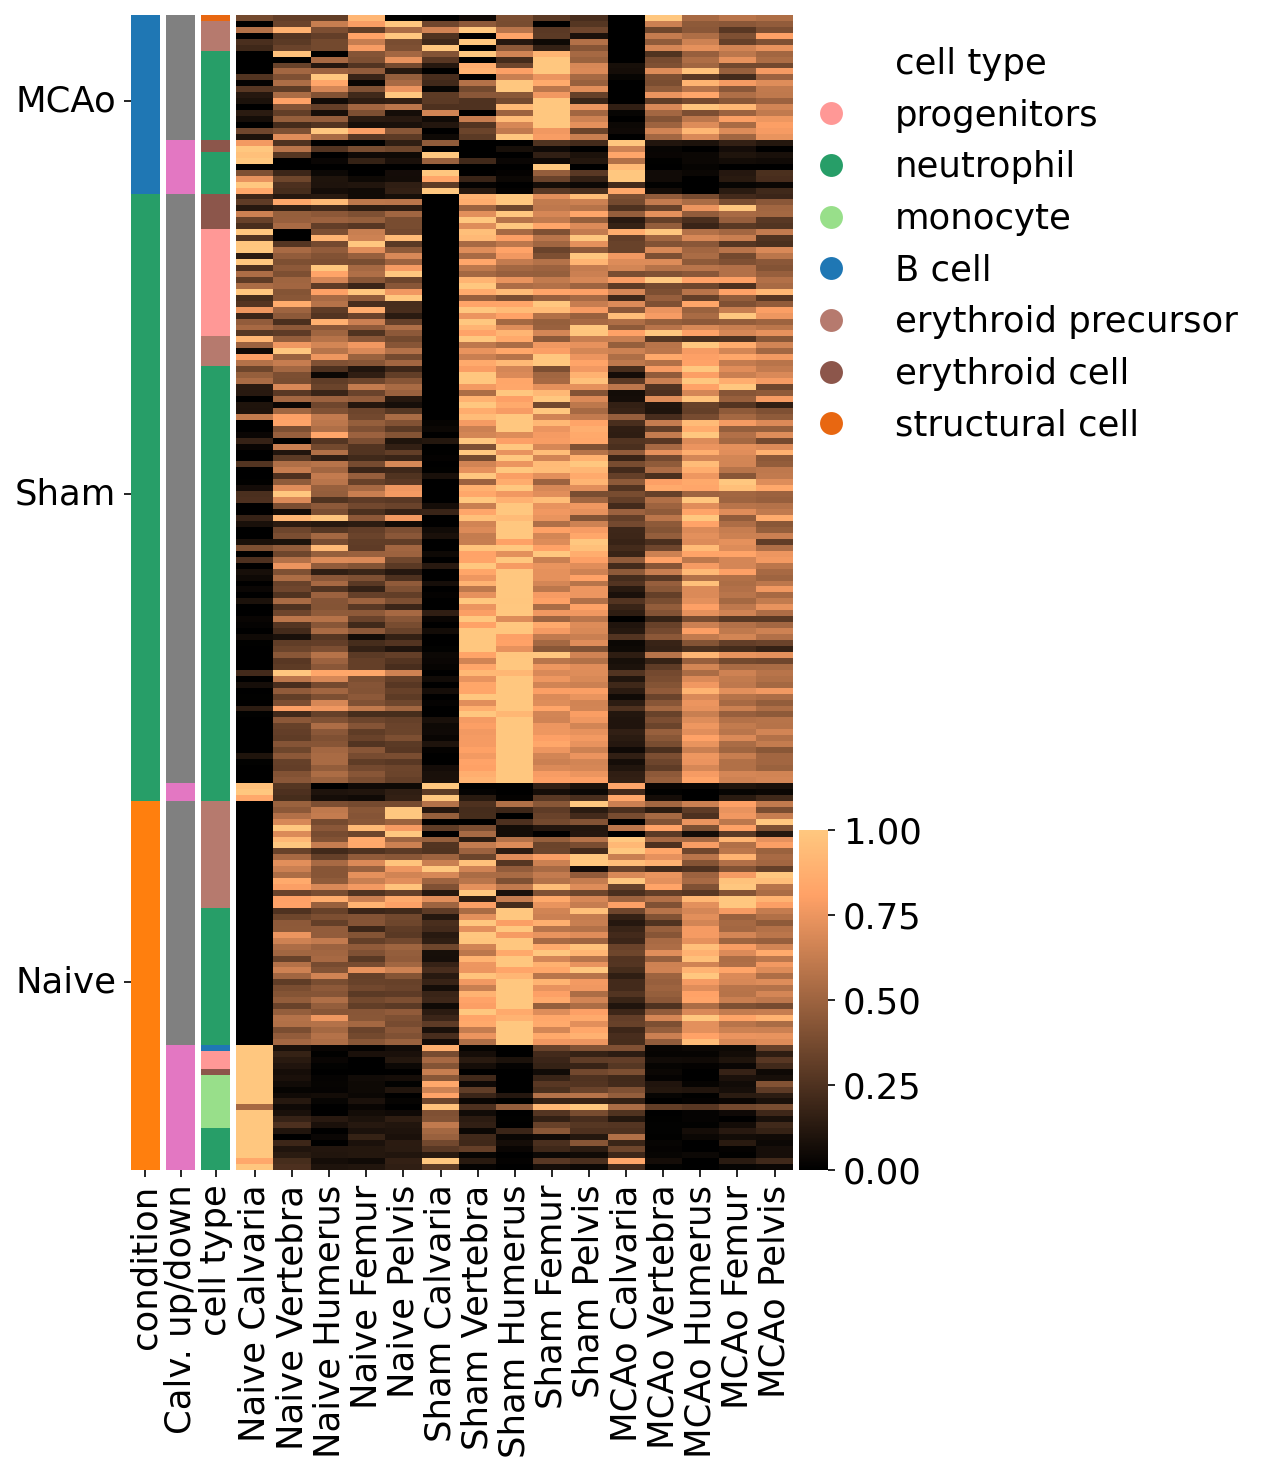

In [9]:
DE_heatmap(df,adata,ct_key="level1",figsize=(6,10),show=True,save=False,#"./figures/expr_heatmap.pdf",
           dpi=200,reverse_df=True)

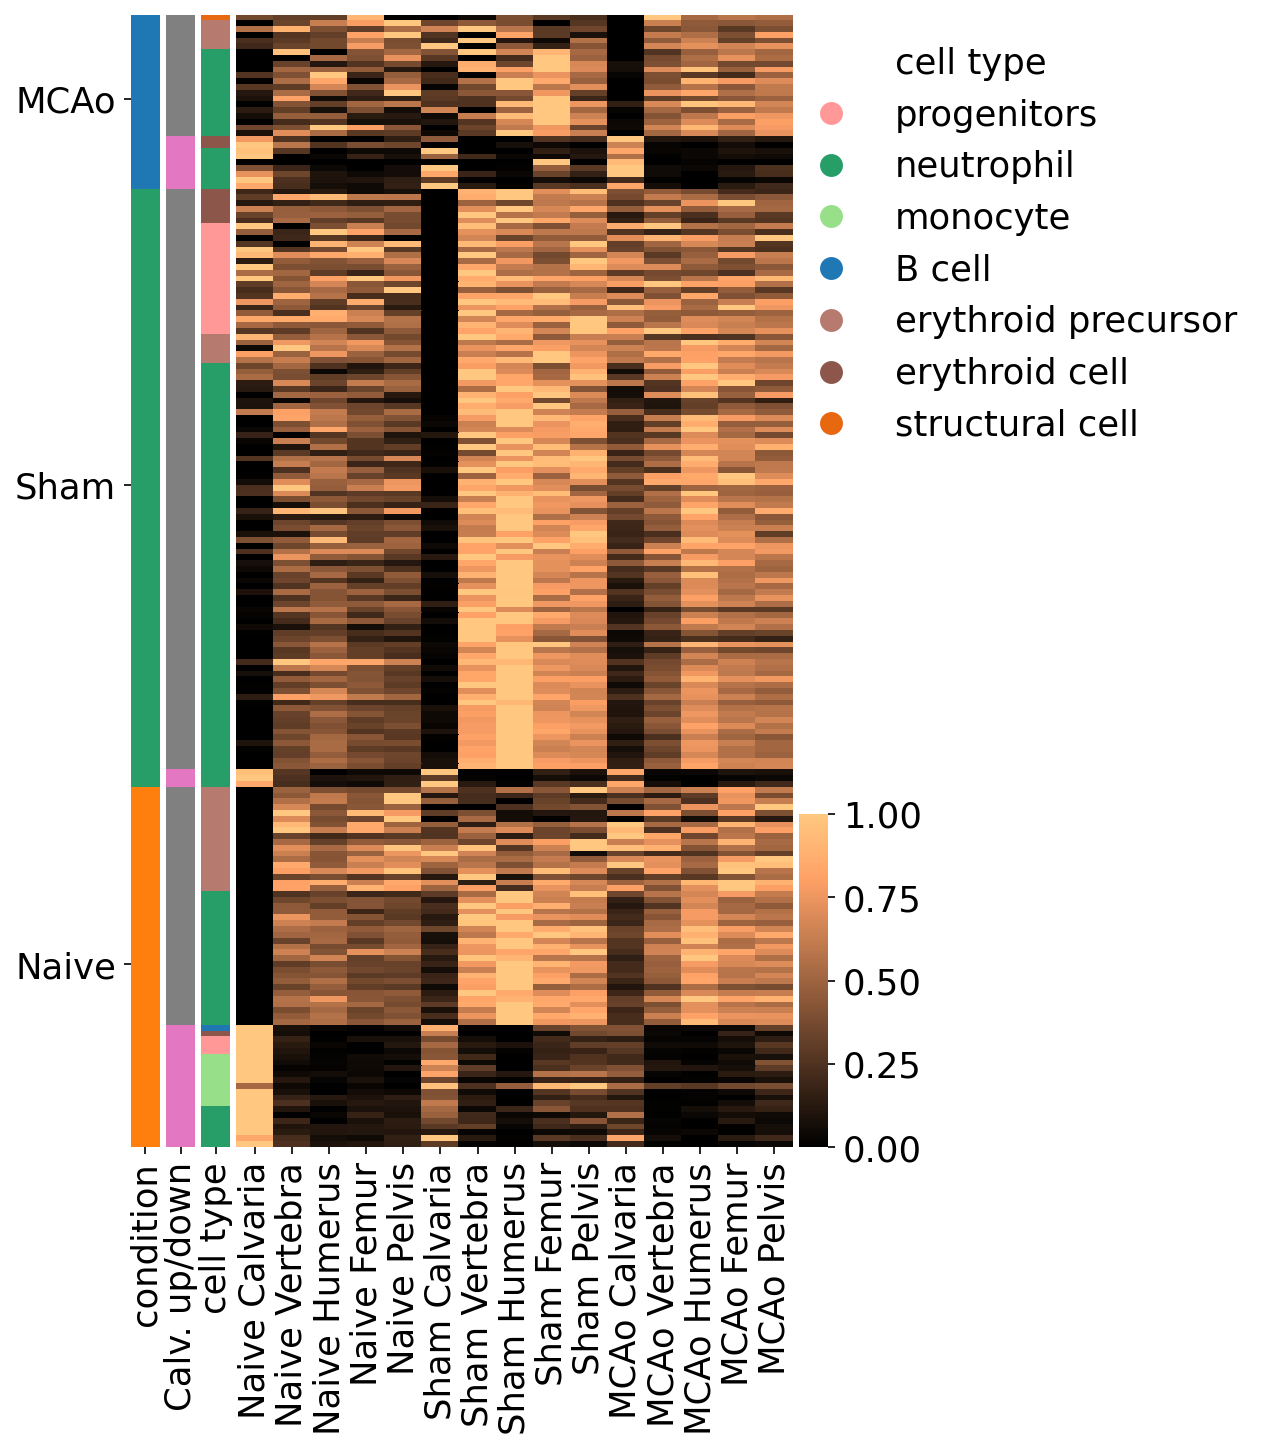

In [59]:
DE_heatmap(df,adata,ct_key="level1",figsize=(6,10),show=True,save="./figures/expr_heatmap.pdf",
           dpi=200,reverse_df=True)

### level2 

In [9]:
df = DE_heatmap_df(adata,ct_key="level2",pval_max=0.05,LFchange_min=2,min_genes_per_comb=5)
df = DE_df_skull_to_calvaria(df)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


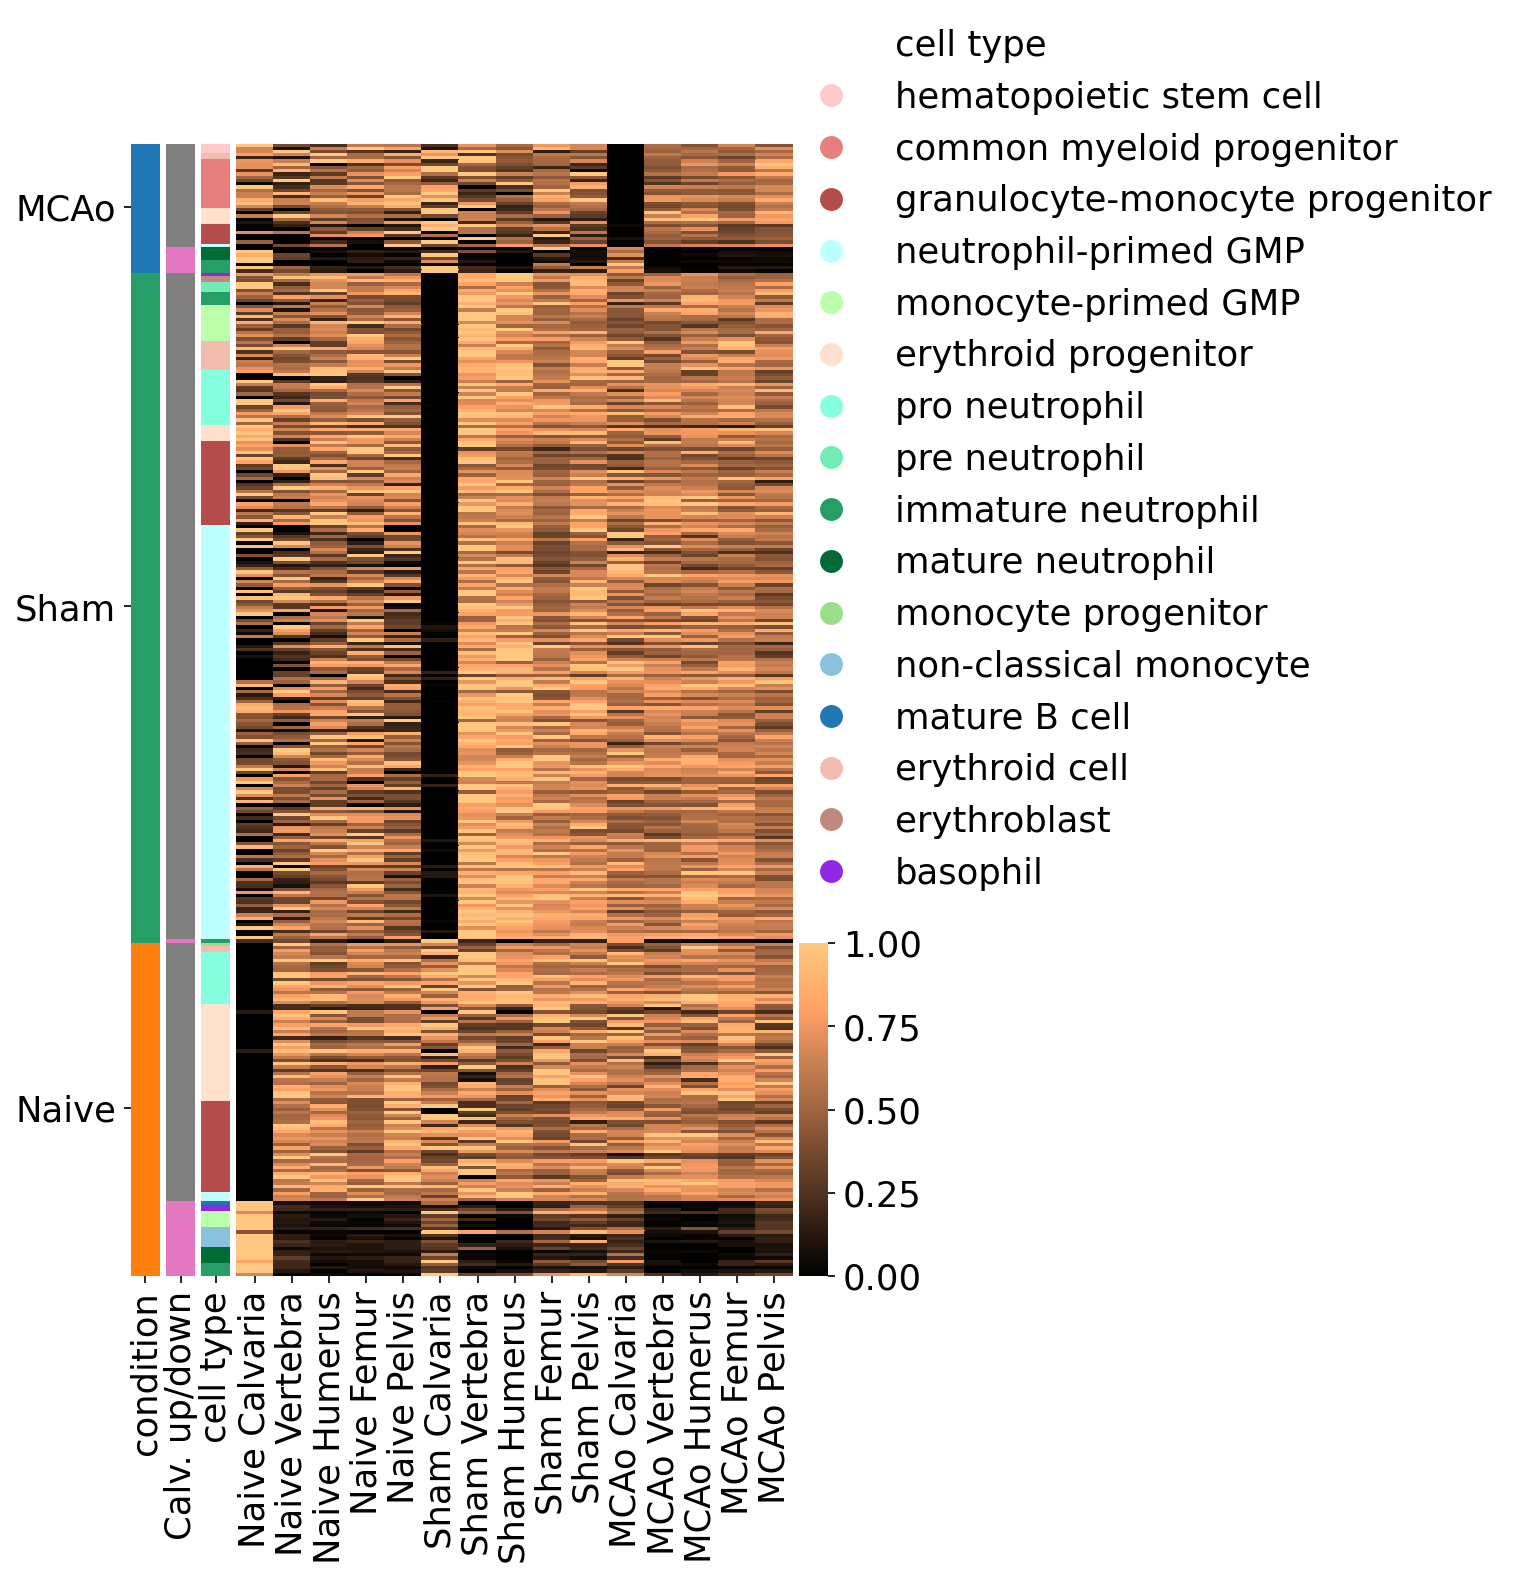

In [10]:
DE_heatmap(df,adata,ct_key="level2",figsize=(6,10),show=True,save="./figures/expr_heatmap_level2.pdf",
           dpi=200,reverse_df=True, ct_leg_y_pos=1.2)

### level2, LFchange > 1

In [10]:
df = DE_heatmap_df(adata,ct_key="level2",pval_max=0.05,LFchange_min=1,min_genes_per_comb=5)
df = DE_df_skull_to_calvaria(df)

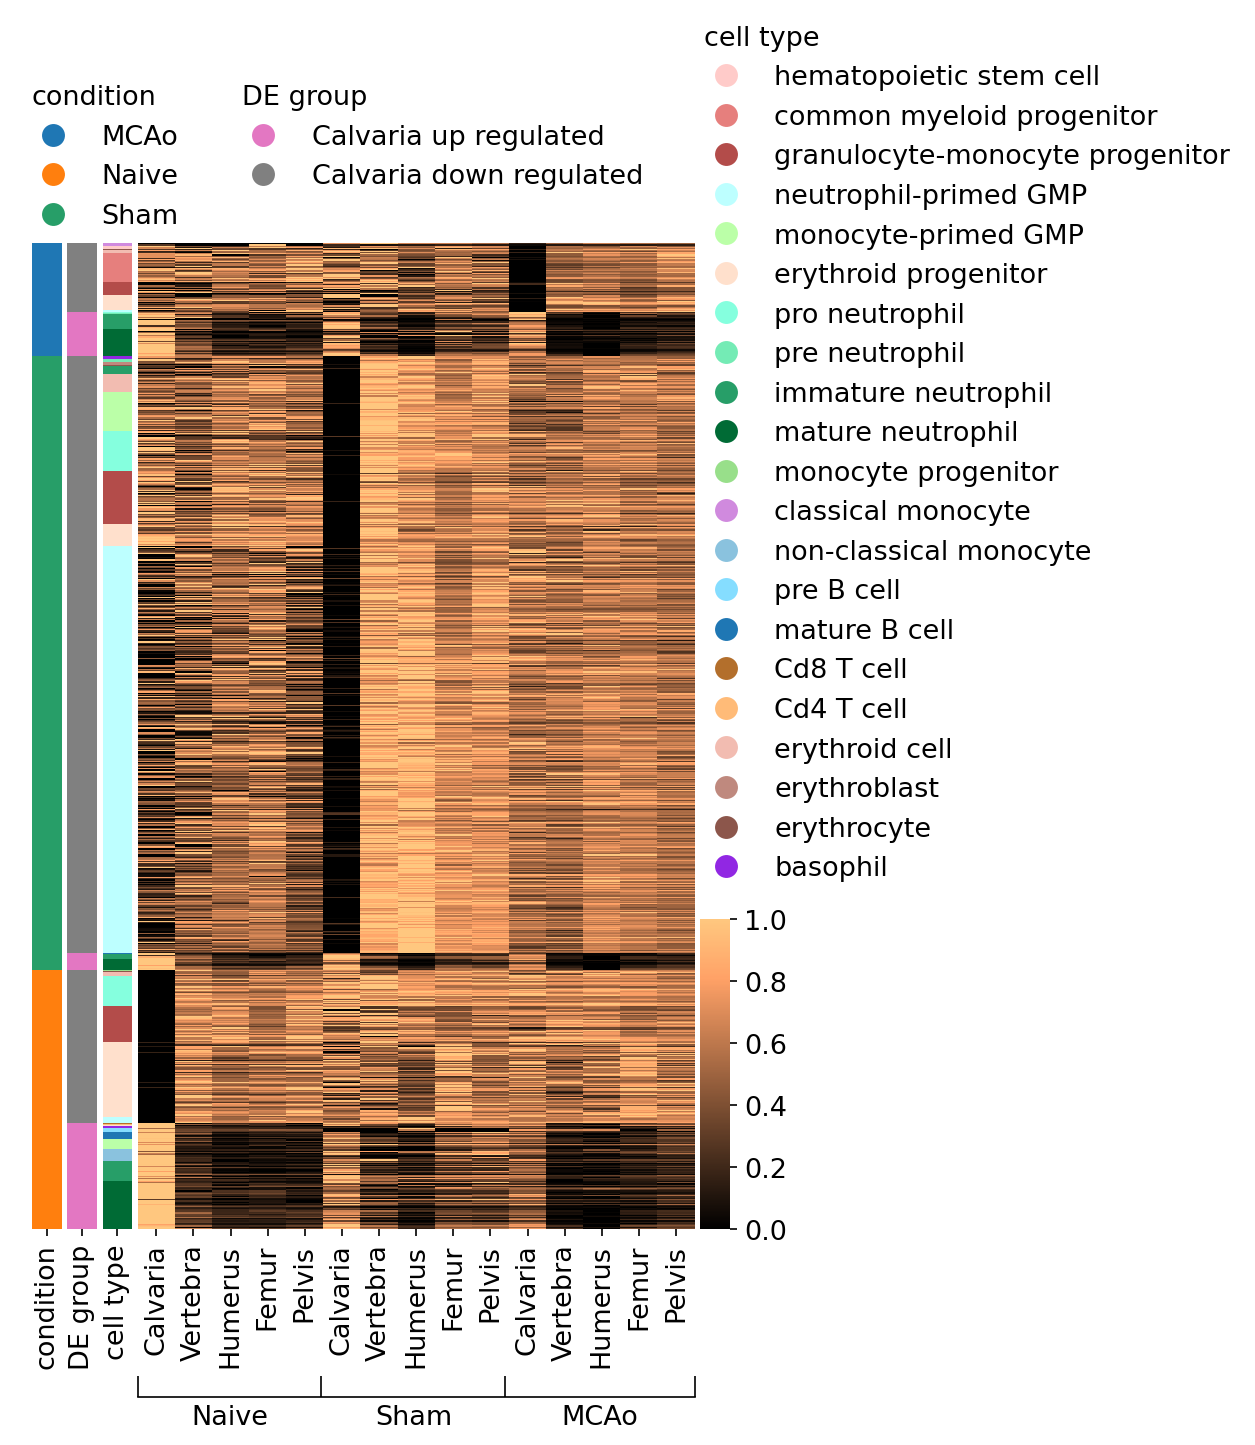

In [73]:
DE_heatmap(df,adata,ct_key="level2",figsize=(6,10),show=True,save="./figures/expr_heatmap_level2_LFc_1.png",
           dpi=200,reverse_df=True, ct_leg_y_pos=1.09)